In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


In [2]:
from src.data_loader import ViTDataLoader
from src.vit_train import load_model_dir, load_model_config
from src.vit_data import load_cell_cycle_data
import importlib

model_dir = 'output/cell_cycle_24x128_2chan_p1_logfold_simple_20220819_319e'

config_path = f"{model_dir.replace('/', '.')}.config"
config = importlib.import_module(config_path)
vit = load_model_config(config, legacy=False)

vit_data = load_cell_cycle_data(config.REPLICATE_MODE, config.CHANNEL_1, config.PREDICT_TPM)


In [3]:
vit_data.all_imgs_untransformed.shape

(57551, 2, 24, 128)

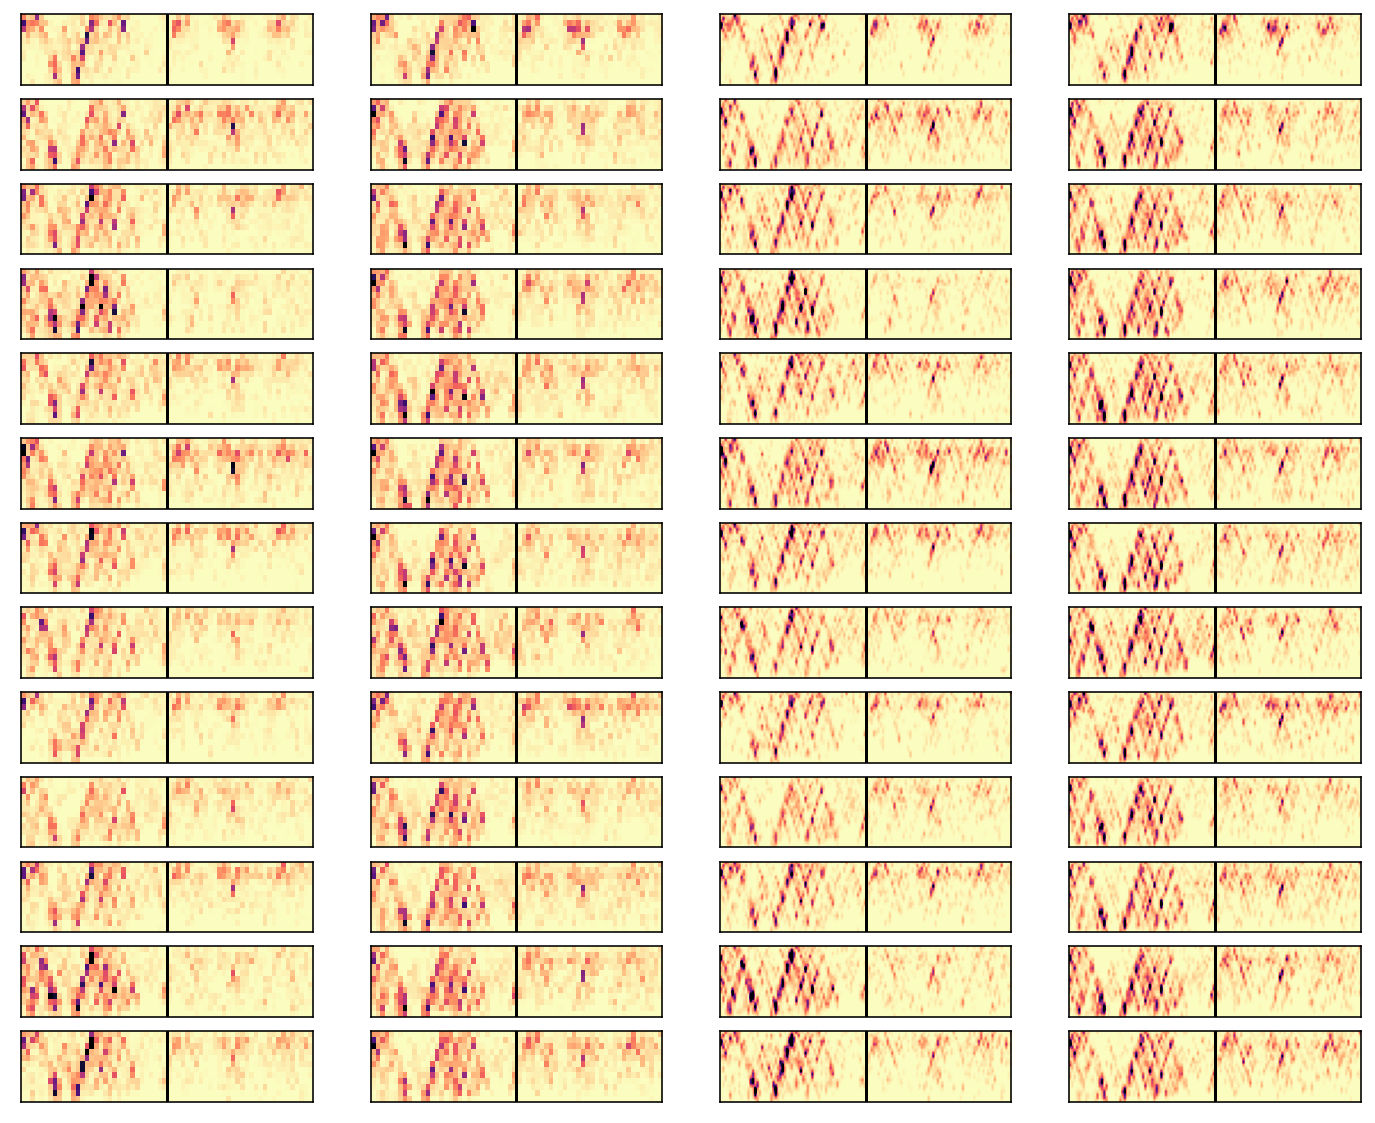

In [658]:
import cv2

imgs = vit_data.all_imgs_untransformed
scale_down = 2
orig_shape = img.shape
new_shape = (img.shape[1]//scale_down, img.shape[0]//scale_down)
    
def plt_hm(gene_name, time, replicate, imgs, img_shape=None):

    idx = vit_data.index_for(gene_name, time)
    img = np.array(imgs[idx, replicate])
    if img_shape is not None:
        img_resize = cv2.resize(img, img_shape)
    else: img_resize = img

    plt.imshow(img_resize, origin='lower', vmin=0, vmax=0.25, cmap='magma_r', aspect='auto',
              extent=[-8, 8, 0, 3])
    plt.axvline(0, c='black')
    plt.yticks([])
    plt.xticks([])
    return img_resize
    
    
times = list(set(vit_data.times))
gene_name = 'CLB2'

new_imgs = np.zeros((len(times), 2, new_shape[1], new_shape[0]))

plt.figure(figsize=(12, 10))
for i in range(len(times)):
    
    time = times[i]    
    
    plt.subplot(len(times), 4, (i*4)+1)
    new_imgs[i, 0] = plt_hm(gene_name, time, 0, imgs, new_shape)
        
    plt.subplot(len(times), 4, (i*4)+2)
    new_imgs[i, 1] = plt_hm(gene_name, time, 1, imgs, new_shape)
    
    plt.subplot(len(times), 4, (i*4)+3)
    plt_hm(gene_name, time, 0, imgs, None)
    
    plt.subplot(len(times), 4, (i*4)+4)
    plt_hm(gene_name, time, 1, imgs, None)
    

In [659]:
new_imgs.shape

(13, 2, 12, 64)

In [660]:
scaled_imgs = np.zeros_like(new_imgs)

time, rep = 0, 0

for time in range(new_imgs.shape[0]):
    for rep in range(new_imgs.shape[1]):
        img_sum = np.sum(new_imgs[time, rep])
        scaled_imgs[time, rep] = new_imgs[time, rep] / img_sum


In [661]:
scaled_imgs.shape

(13, 2, 12, 64)

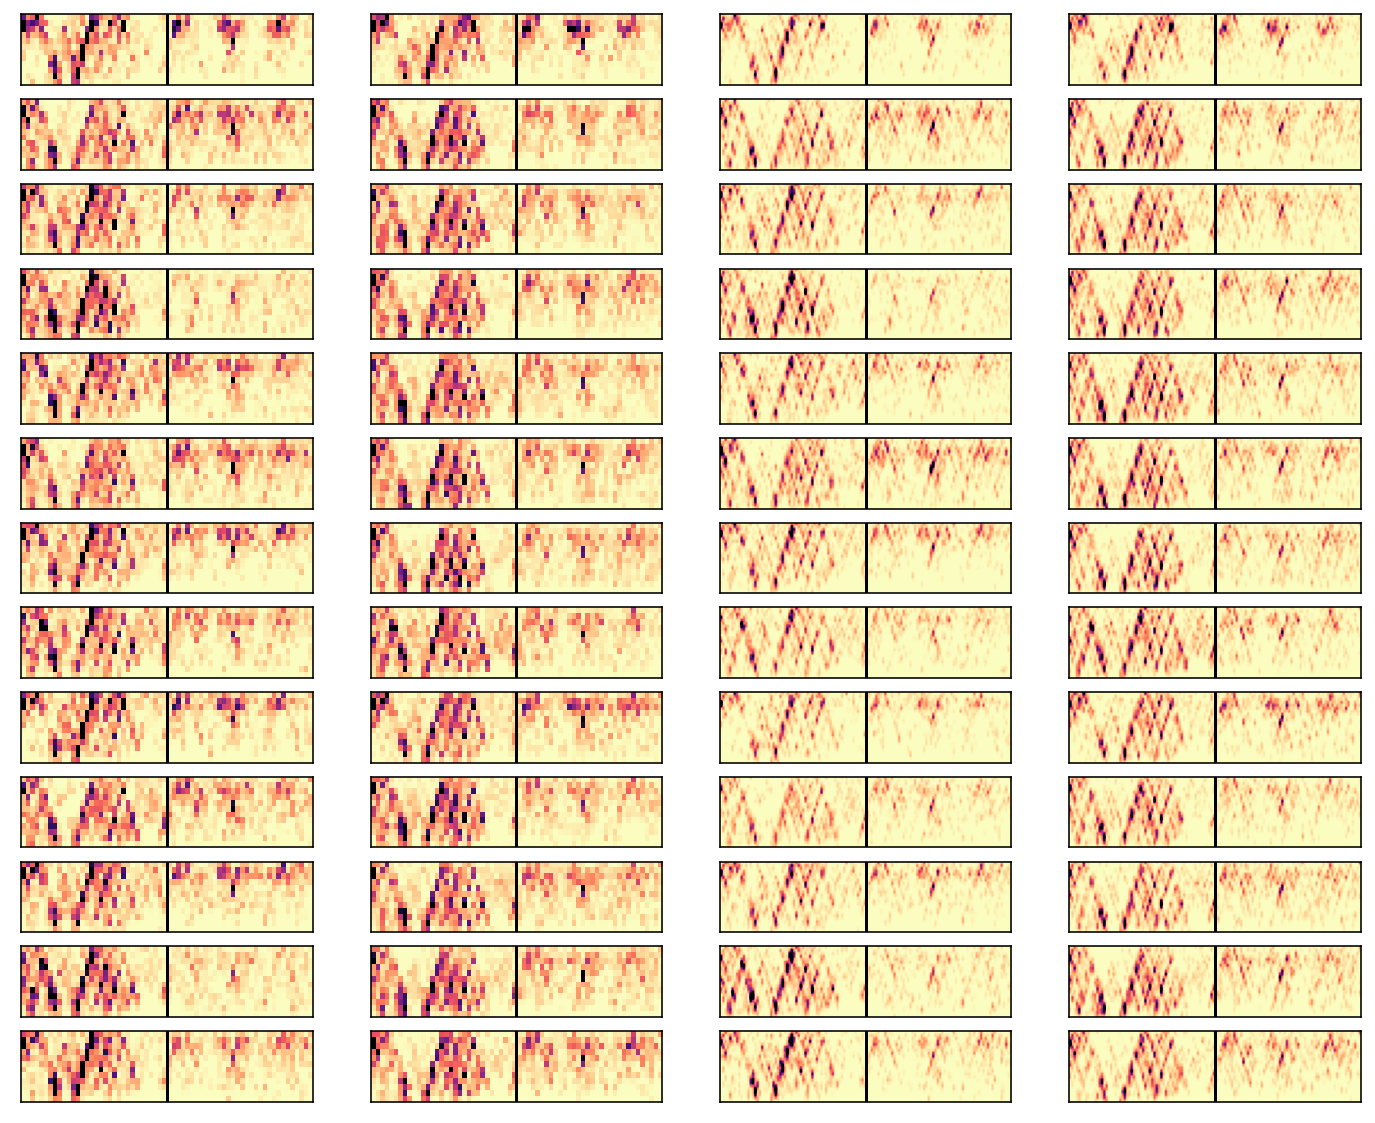

In [671]:
import cv2

imgs = vit_data.all_imgs_untransformed

plt.figure(figsize=(12, 10))
for i in range(len(times)):
    
    time = times[i]    
    
    plt.subplot(len(times), 4, (i*4)+1)
    plt.imshow(scaled_imgs[i, 0], vmax=0.01, origin='lower', cmap='magma_r', extent=[-16, 16, 0, 3], aspect='auto')
    plt.axvline(0, c='black')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(len(times), 4, (i*4)+2)
    plt.imshow(scaled_imgs[i, 1], vmax=0.01, origin='lower', cmap='magma_r', extent=[-16, 16, 0, 3], aspect='auto')
    plt.axvline(0, c='black')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(len(times), 4, (i*4)+3)
    plt_hm(gene_name, time, 0, imgs, None)
    
    plt.subplot(len(times), 4, (i*4)+4)
    plt_hm(gene_name, time, 1, imgs, None)
    

In [663]:
new_imgs.shape

(13, 2, 12, 64)

In [664]:
import h5py

# save the array to an HDF5 file
with h5py.File(f'output/deconvolution/clb2_{new_imgs.shape[2]}x{new_imgs.shape[3]}.h5', 'w') as f:
    f.create_dataset('data', data=scaled_imgs)


In [231]:
# import h5py

# # save the array to an HDF5 file
# with h5py.File('output/deconvolution/clb2_6x32.h5', 'w') as f:
#     f.create_dataset('data', data=new_imgs)


In [6]:
import h5py 

# open the HDF5 file
filename = 'output/deconvolution/clb2_3x16_deconvolved.h5'
f = h5py.File(filename, 'r')

# read the dataset into a numpy array
deconvolved_clb2 = f['/data'][:]
deconvolved_clb2.shape
heatmaps = deconvolved_clb2

In [7]:
modelIntervals = pd.read_csv('output/deconvolution/modelIntervals.csv')

colorMap = {
    "R": np.array([199, 148, 144])/255.,
    "CG1": np.array([147, 168, 198])/255.,
    "DG1": np.array([165, 197, 204])/255.,
    "postG1": np.array([223, 192, 158])/255.}


cg1Length = modelIntervals[modelIntervals.phase == 'CG1'].timepoint.max()
dg1Length = modelIntervals[modelIntervals.phase == 'DG1'].timepoint.max() - \
    modelIntervals[modelIntervals.phase == 'DG1'].timepoint.min()
postG1Length = modelIntervals[modelIntervals.phase == 'postG1'].timepoint.max() - \
    modelIntervals[modelIntervals.phase == 'postG1'].timepoint.min()

modelIntervals['translatedTimepoints'] = modelIntervals.timepoint
modelIntervals['yPlot'] = 0.
bottomSel = modelIntervals.branch == 'bottom'
modelIntervals.loc[bottomSel, 'translatedTimepoints'] = \
    modelIntervals.loc[bottomSel, 'timepoint'] + dg1Length + postG1Length
modelIntervals.loc[bottomSel, 'yPlot'] = -1

topSel = modelIntervals.branch == 'top'
modelIntervals.loc[topSel, 'translatedTimepoints'] = \
    modelIntervals.loc[topSel, 'timepoint'] + cg1Length + postG1Length
modelIntervals.loc[topSel, 'yPlot'] = 1

In [8]:
# # open the HDF5 file
# filename = 'output/deconvolution/clb2_6x32_deconvolved.h5'
# f = h5py.File(filename, 'r')

# # read the dataset into a numpy array
# deconvolved_clb2 = f['/data'][:]
# deconvolved_clb2.shape

In [9]:
def plot_current_index(ax, current_index=None):

    def plot_phase_branch(branchName, current_index):

        if current_index is None:
            rows = modelIntervals[modelIntervals.branch == branchName]
            for phase in rows.phase.unique():    
                phaseRows = rows[rows.phase == phase]
                indices = phaseRows.translatedTimepoints
                ax.plot(indices, phaseRows.yPlot, color=colorMap[phase], lw=24, solid_capstyle='butt')
                ax.text(indices.min()/2+indices.max()/2, phaseRows.yPlot.min()-0.08, phase, 
                         c='white', fontsize=16, ha='center',
                        fontdict={'family': 'Helvetica'})

        if current_index is not None:
            plt.axhline(1.5, c='white', lw=25, zorder=2)
            plt.axhline(0.5, c='white', lw=25, zorder=2)
            plt.axhline(-0.5, c='white', lw=25, zorder=2)
            currentMarker = modelIntervals[modelIntervals['index'] == current_index]
            plt.scatter(currentMarker.translatedTimepoints, currentMarker.yPlot+0.35,
                        c='black', zorder=2, marker='v', s=50)
        
    plot_phase_branch('initial', current_index)
    plot_phase_branch('top', current_index)
    plot_phase_branch('bottom', current_index)

def create_axs(heatmaps):
    # customize the heatmap appearance using matplotlib
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    im = ax1.imshow(heatmaps[0], origin='lower', cmap='magma_r', extent=[-512, 512, 0, 256], aspect='auto')
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.set_xticks([])
    ax2.set_yticks([])    
    plot_current_index(ax2)

    ax2.set_ylim(-3, 2)
    
    return fig, ax1, ax2, im

def plot_i(im, heatmaps, ax1, ax2, i):
    im.set_data(heatmaps[i])
    ax1.axvline(0, c='black')

    plot_current_index(ax2, i)


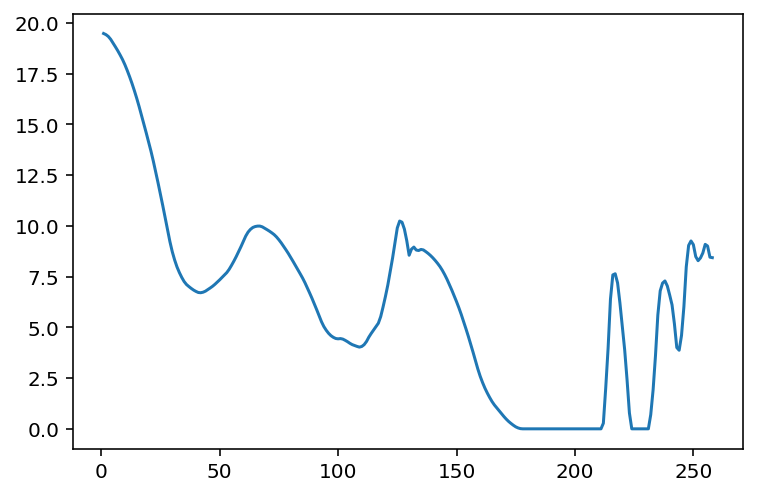

In [10]:
heatmaps.shape

x = range(1, len(heatmaps))
plt.plot(x, heatmaps[x, 2, 8])


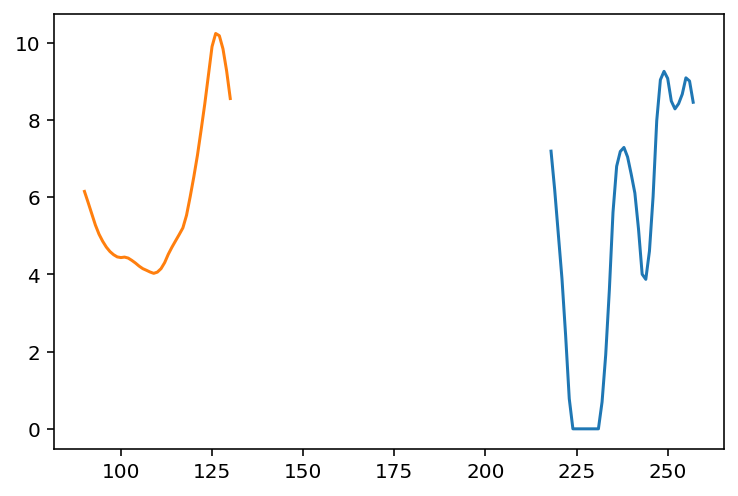

In [11]:
heatmaps.shape

#x = range(90, 131)
#plt.plot(x, heatmaps[x, 2, 8])

x = range(218, 258)
plt.plot(x, heatmaps[x, 2, 8])

x = range(90, 131)
plt.plot(x, heatmaps[x, 2, 8])


In [12]:
modelIntervals[modelIntervals.phase == 'postG1']

,branch,phase,index,timepoint,translatedTimepoints,yPlot
130,initial,postG1,218,19.8774,19.8774,0.0
131,initial,postG1,219,20.9811,20.9811,0.0
132,initial,postG1,220,22.0849,22.0849,0.0
133,initial,postG1,221,23.1887,23.1887,0.0
134,initial,postG1,222,24.2924,24.2924,0.0
...,...,...,...,...,...,...
379,bottom,postG1,255,60.7168,148.5280,-1.0
380,bottom,postG1,256,61.8205,149.6317,-1.0
381,bottom,postG1,257,62.9243,150.7355,-1.0
382,bottom,postG1,258,64.0281,151.8393,-1.0


00:01:09.77


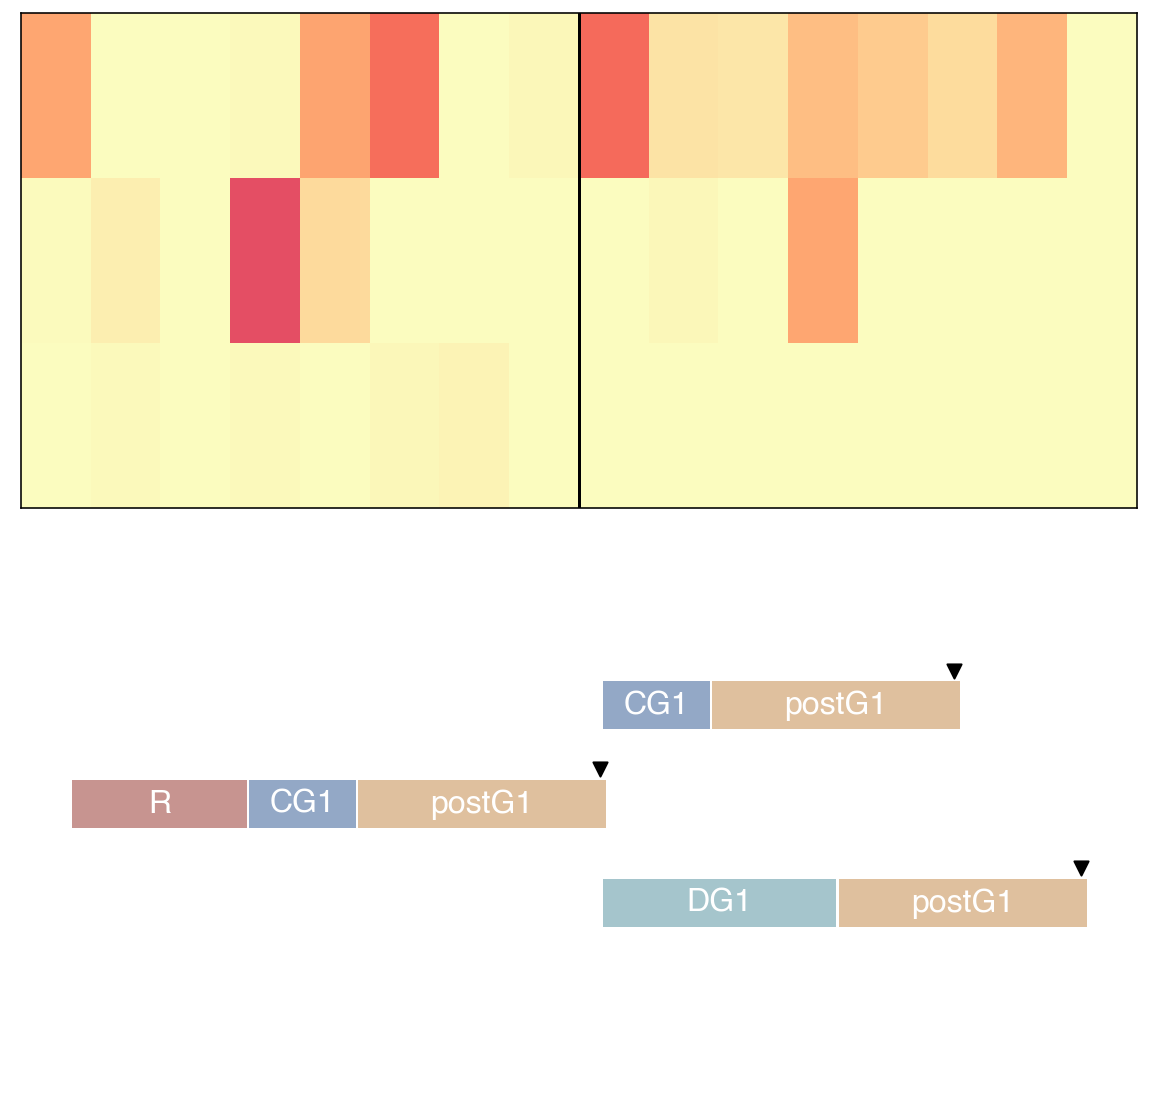

In [14]:
from src.timer import Timer

timer = Timer()

phaseOrder = [('initial', 'R'), ('initial', 'CG1'), 
              ('initial', 'postG1'), 
              ('bottom', 'DG1'), 
              ('bottom', 'postG1')]

fig, ax1, ax2, im = create_axs(heatmaps)

imageIndex = 0
for branch, phase in phaseOrder:
    curPhaseRows = modelIntervals[(modelIntervals.phase == phase) & (modelIntervals.branch == branch)]
    for indexInH in curPhaseRows['index']:
        
        if indexInH >= len(heatmaps): continue

        plot_i(im, heatmaps, ax1, ax2, indexInH)

        filename = 'output/deconvolution/clb2/clb2_deconvolved_{}.png'.format(imageIndex)
        fig.savefig(filename, dpi=100)

        imageIndex += 1

timer.print_time()


In [15]:
import imageio

filenames = [f'output/deconvolution/clb2/clb2_deconvolved_{i}.png' for i in range(0, imageIndex)]

# create an animated GIF from the PNG files
with imageio.get_writer('output/deconvolution/clb2.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
